In [128]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import tensorflow as tf
keras = tf.keras
K = keras.backend

from resnet import Resnet18
from model import BiSeNet

In [2]:
def load_pytorch_model(save_path=os.path.join("res/cp", "79999_iter.pth"),
                       n_classes=19):
    net = BiSeNet(n_classes=n_classes)
#     net.cuda()
    
    net.load_state_dict(torch.load(save_path))
#     net.eval()

    return net

In [216]:
class Conv2D(keras.layers.Layer):
    def __init__(self, filters, kernel_size, strides=1, padding=0, *pargs, **kwargs):
        super(Conv2D, self).__init__()
        
        self.filters = filters
        self.kernel_size = kernel_size
        self.strides = strides
        self.padding = padding
        
        self.pad = keras.layers.ZeroPadding2D(padding=self.padding)
        self.conv = keras.layers.Conv2D(filters, 
                                        kernel_size=self.kernel_size,
                                        strides=self.strides,
                                        padding="valid", 
                                        *pargs, **kwargs)
    
    def call(self, x):
        x = self.pad(x)
        x = self.conv(x)
        return x
    
    def set_weights(self, weights):
        print("Conv2D set_weights() called.")
        self.conv.set_weights(weights)
        
        
class MaxPool2D(keras.layers.Layer):
    def __init__(self, pool_size=(2, 2), strides=None, padding=0, *pargs, **kwargs):
        super(MaxPool2D, self).__init__()
        
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
        
        self.pad = keras.layers.ZeroPadding2D(padding=self.padding)
        self.pool = keras.layers.MaxPool2D(pool_size=self.pool_size,
                                           strides=self.strides if self.strides is not None else self.pool_size, 
                                           padding="valid")
    
    def call(self, x):
        x = self.pad(x)
        x = self.pool(x)
        return x

## Convert Resnet18

In [4]:
net = Resnet18()
net = net.eval()

x = torch.randn(16, 3, 224, 224)
out = net(x)
print(out[0].size())
print(out[1].size())
print(out[2].size())

torch.Size([16, 128, 28, 28])
torch.Size([16, 256, 14, 14])
torch.Size([16, 512, 7, 7])


In [5]:
net

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [6]:
def filter_dict_by_name(name, state_dict):
    return dict(filter(lambda t: t[0].startswith(name + "."),  state_dict.items()))


def strip_dict_key_prefix(state_dict, cut=1):
    """Strip parameter key prefix."""
    return {f"{'.'.join(k.split('.')[cut:])}": v for k, v in state_dict.items()}


def conv2d_weights_pth2tf(params_dict):
    """Convert conv2d weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias"]:
        if key not in params_dict:
            continue
            
        if key == "weight":
            weights.append(params_dict[key].permute(2, 3, 1, 0).detach().cpu().numpy())
        else:
            weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def bn_weights_pth2tf(params_dict):
    """Convert batch norm weights from Pytorch to TensorFlow."""
    
    weights = []
    
    # gamma, beta, moving_mean, moving_variance
    for key in ["weight", "bias", "running_mean", "running_var"]:
        weights.append(params_dict[key].detach().cpu().numpy())
    
    return weights


def get_weight_conversion_fn(layer):
    """Get the appropriate weight conversion function given the layer."""
    
    if isinstance(layer, (keras.layers.Conv2D, Conv2D)):
        fn = conv2d_weights_pth2tf
    elif isinstance(layer, keras.layers.BatchNormalization):
        fn = bn_weights_pth2tf
    else:
        raise Exception(f"Unknown layer type: {type(layer)}")
        
    return fn


def th2tf_conv(prefix, state_dict):
    w = state_dict.get(f'{prefix}weight')
    b = state_dict.get(f'{prefix}bias', None)
    weights = [w.permute(2, 3, 1, 0).detach().cpu().numpy(), ]
    if b is not None: weights += [b.detach().cpu().numpy(), ]
    return weights

In [7]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
#     return keras.layers.Conv2D(
# #         in_planes,
#         out_planes,
#         kernel_size=3,
#         strides=stride,
#         padding="same",
#         use_bias=False
#     )
    return Conv2D(
#         in_planes,
        out_planes,
        kernel_size=3,
        strides=stride,
        padding=1,
        use_bias=False
    )


class BasicBlock(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = conv3x3(in_chan, out_chan, stride)
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = conv3x3(out_chan, out_chan)
        self.bn2 = keras.layers.BatchNormalization()
#         self.relu = nn.ReLU(inplace=True)
#         self.relu = keras.activations.relu
        self.relu = keras.layers.Activation("relu")
    
        self.downsample = None
        if in_chan != out_chan or stride != 1:
            self.downsample = keras.models.Sequential()
            self.downsample.add(
                Conv2D(
#                     in_chan,
                    out_chan,
                    kernel_size=1,
                    strides=stride,
                    use_bias=False
                )
            )
            self.downsample.add(
                keras.layers.BatchNormalization()
            )

    def call(self, x, training=False):
        residual = self.conv1(x)
        residual = K.relu(self.bn1(residual, training=training))
        residual = self.conv2(residual)
        residual = self.bn2(residual, training=training)

        shortcut = x
        if self.downsample is not None:
            shortcut = self.downsample(x)

        out = shortcut + residual
        out = self.relu(out)
        return out
    
    def load_weigths_pytorch(self, state_dict):
        for layer_name in [
            "conv1",
            "bn1",
            "conv2",
            "bn2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)

            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}")
#             print(layer_state_dict)
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
        
        if self.downsample:
            print(f"{self.__class__.__name__}: self.downsample not None...")
            
            for idx, layer in enumerate(self.downsample.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"downsample.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")


def create_layer_basic(in_chan, out_chan, bnum, stride=1):
    model = keras.models.Sequential()
    model.add(BasicBlock(in_chan, out_chan, stride=stride))
    for i in range(bnum - 1):
        model.add(BasicBlock(out_chan, out_chan, stride=1))
    return model


class TFResnet18(keras.models.Model):
    def __init__(self):
        super(TFResnet18, self).__init__()
        
#         self.conv1 = keras.layers.Conv2D(
# #             3, 
#             64, 
#             kernel_size=7, 
#             strides=2, 
#             padding="same",
#             use_bias=False
#         )
        self.conv1 = Conv2D(
            64,
            kernel_size=7,
            strides=2,
            padding=3,
            use_bias=False
        )
        self.bn1 = keras.layers.BatchNormalization()
#         self.maxpool = keras.layers.MaxPool2D(3, strides=2, padding="same")
        self.maxpool = MaxPool2D(3, strides=2, padding=1)
        self.layer1 = create_layer_basic(64, 64, bnum=2, stride=1)
        self.layer2 = create_layer_basic(64, 128, bnum=2, stride=2)
        self.layer3 = create_layer_basic(128, 256, bnum=2, stride=2)
        self.layer4 = create_layer_basic(256, 512, bnum=2, stride=2)

    def call(self, x, training=False):
        x = self.conv1(x)
        x = K.relu(self.bn1(x, training=training))
        x = self.maxpool(x)

        x = self.layer1(x, training=training)
        feat8 = self.layer2(x, training=training) # 1/8
        feat16 = self.layer3(feat8, training=training) # 1/16
        feat32 = self.layer4(feat16, training=training) # 1/32
        return feat8, feat16, feat32
    
    def load_weights_pytorch(self, state_dict):
        dummy_input = tf.random.normal((16, 224, 224, 3))
        _ = self.predict(dummy_input)
        
        for layer_name in ["conv1", "bn1"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")
            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            
            print()
        
        for seq_layer_name in [f"layer{i+1}" for i in range(4)]:
            seq_layer = getattr(self, seq_layer_name)
    
            print(f"{self.__class__.__name__}: Sequential layer: {seq_layer_name}")
            
            for idx, layer in enumerate(seq_layer.layers):
                print(f"{self.__class__.__name__}: \tidx: {idx}, layer type: {layer.__class__.__name__}")

                layer_state_dict = filter_dict_by_name(f"{seq_layer_name}.{idx}", state_dict)
                layer_state_dict = strip_dict_key_prefix(layer_state_dict, cut=2)
    #             print(layer_state_dict)
                layer.load_weigths_pytorch(layer_state_dict)
        
            print()
        
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [8]:
net_tf = TFResnet18()
# x = tf.random.normal((16, 224, 224, 3))
# out = net_tf(x)
# print(out[0].shape)
# print(out[1].shape)
# print(out[2].shape)

In [9]:
resnet18_state_dict = torch.load("resnet18-5c106cde.pth")

In [10]:
net_tf.load_weights_pytorch(resnet18_state_dict)

TFResnet18: Setting weight for layer: conv1, type: Conv2D
TFResnet18: layer_state_dict keys: ['weight']

TFResnet18: Setting weight for layer: bn1, type: BatchNormalization
TFResnet18: layer_state_dict keys: ['running_mean', 'running_var', 'weight', 'bias']

TFResnet18: Sequential layer: layer1
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!
TFResnet18: 	idx: 1, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!

TFResnet18: Sequential layer: layer2
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for l

In [11]:
list(resnet18_state_dict.keys())

['conv1.weight',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.weight',
 'bn1.bias',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.running_mean',
 'layer1.1.bn2.running_var',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.running_mean',
 'layer2.0.bn2.running_var',
 'layer2.0.bn2.weight',
 'layer2.0.bn2.bias',
 'layer2.0.downsample.0.weight',
 'layer2.0.downsample.1.running_mean',
 'layer2.0.downsample.1.running_var',
 'layer2.0.downsam

In [12]:
list(net.state_dict().keys())

['conv1.weight',
 'bn1.weight',
 'bn1.bias',
 'bn1.running_mean',
 'bn1.running_var',
 'bn1.num_batches_tracked',
 'layer1.0.conv1.weight',
 'layer1.0.bn1.weight',
 'layer1.0.bn1.bias',
 'layer1.0.bn1.running_mean',
 'layer1.0.bn1.running_var',
 'layer1.0.bn1.num_batches_tracked',
 'layer1.0.conv2.weight',
 'layer1.0.bn2.weight',
 'layer1.0.bn2.bias',
 'layer1.0.bn2.running_mean',
 'layer1.0.bn2.running_var',
 'layer1.0.bn2.num_batches_tracked',
 'layer1.1.conv1.weight',
 'layer1.1.bn1.weight',
 'layer1.1.bn1.bias',
 'layer1.1.bn1.running_mean',
 'layer1.1.bn1.running_var',
 'layer1.1.bn1.num_batches_tracked',
 'layer1.1.conv2.weight',
 'layer1.1.bn2.weight',
 'layer1.1.bn2.bias',
 'layer1.1.bn2.running_mean',
 'layer1.1.bn2.running_var',
 'layer1.1.bn2.num_batches_tracked',
 'layer2.0.conv1.weight',
 'layer2.0.bn1.weight',
 'layer2.0.bn1.bias',
 'layer2.0.bn1.running_mean',
 'layer2.0.bn1.running_var',
 'layer2.0.bn1.num_batches_tracked',
 'layer2.0.conv2.weight',
 'layer2.0.bn2.weigh

In [13]:
net.load_state_dict(resnet18_state_dict, strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['fc.weight', 'fc.bias'])

In [14]:
conv1_tf = keras.layers.Conv2D(
    64,
    kernel_size=7,
    strides=2,
    padding="same",
    use_bias=False,
)

In [15]:
conv1 = torch.nn.Conv2d(
    3,
    64,
    kernel_size=7,
    stride=2,
    padding=3,
    bias=False
)

In [16]:
conv1_tf_v2 = Conv2D(
    64,
    kernel_size=7,
    strides=2,
    padding=3,
    use_bias=False,
)

In [17]:
conv1_state_dict = conv1.state_dict()

In [18]:
conv1_state_dict.keys()

odict_keys(['weight'])

In [19]:
conv1.load_state_dict(
    conv1_state_dict
)

<All keys matched successfully>

In [20]:
conv1.eval()

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

In [21]:
fixed_input = np.random.rand(16, 224, 224, 3).astype(np.float32)

In [22]:
conv1_tf(fixed_input)

<tf.Tensor: shape=(16, 112, 112, 64), dtype=float32, numpy=
array([[[[-3.40764113e-02,  1.05415821e-01, -4.72918935e-02, ...,
          -1.88565701e-02, -2.13634856e-02,  3.83955776e-04],
         [ 1.51960656e-01, -1.11670559e-03, -1.68919906e-01, ...,
          -3.57445739e-02, -1.08858339e-01, -1.32509291e-01],
         [ 1.01107463e-01,  6.14996068e-02, -9.49589983e-02, ...,
           2.44976109e-04, -8.35892335e-02, -6.16450273e-02],
         ...,
         [-4.38130461e-02, -2.60287970e-02, -6.43447116e-02, ...,
           5.33384047e-02,  4.17062491e-02, -1.52291045e-01],
         [-3.63348909e-02, -4.62393649e-02, -1.54817002e-02, ...,
           1.08650148e-01, -3.58642675e-02, -4.36116867e-02],
         [-7.57072046e-02, -2.94116717e-02, -9.30888504e-02, ...,
           1.13439113e-01,  2.05122810e-02, -4.82085347e-02]],

        [[ 5.74874319e-02,  1.71594784e-01, -1.13420539e-01, ...,
           9.39292368e-03, -7.21746832e-02,  8.55571404e-02],
         [ 7.40845799e-02,  

In [23]:
conv1_tf_v2(fixed_input)

<tf.Tensor: shape=(16, 112, 112, 64), dtype=float32, numpy=
array([[[[ 4.62183952e-02,  1.14501677e-01,  9.54493284e-02, ...,
          -1.55293597e-02, -9.02824998e-02,  4.96836491e-02],
         [ 2.01932207e-01,  2.90221065e-01,  8.96149725e-02, ...,
          -1.27714366e-01, -2.86076926e-02,  2.82090507e-03],
         [ 8.39422569e-02,  2.51317501e-01,  3.48891243e-02, ...,
          -1.11116081e-01, -1.24983333e-01,  1.68463886e-02],
         ...,
         [ 1.08527005e-01,  1.94276378e-01,  6.91471100e-02, ...,
          -1.04163319e-01, -1.13192372e-01, -4.68654111e-02],
         [ 8.45133811e-02,  3.39812100e-01,  1.63138852e-01, ...,
          -8.56798962e-02, -1.01072967e-01, -3.98530588e-02],
         [ 1.51687255e-02,  1.93831712e-01, -6.71087727e-02, ...,
           7.34892115e-03, -1.48577332e-01,  8.20771754e-02]],

        [[ 8.91335830e-02,  5.62615059e-02, -7.52694160e-02, ...,
           7.18537569e-02,  2.20127683e-02,  1.37785420e-01],
         [ 1.01490721e-01,  

In [24]:
conv1_tf.set_weights(
#     th2tf_conv("", conv1_state_dict)
    get_weight_conversion_fn(conv1_tf)(conv1_state_dict)
)

In [25]:
conv1_tf_v2.set_weights(
    th2tf_conv("", conv1_state_dict)
)

In [26]:
conv1.state_dict()["weight"].detach().numpy().shape

(64, 3, 7, 7)

In [27]:
conv1_tf.weights[0].numpy().shape

(7, 7, 3, 64)

In [28]:
np.all(np.equal(
    np.transpose(conv1_tf.weights[0].numpy(), [3, 2, 0, 1]), 
    conv1.state_dict()["weight"].detach().numpy()
))

True

In [29]:
np.all(np.equal(
    np.transpose(conv1_tf_v2.weights[0].numpy(), [3, 2, 0, 1]), 
    conv1.state_dict()["weight"].detach().numpy()
))

True

In [30]:
get_weight_conversion_fn(conv1_tf)(
    conv1_state_dict
)

[array([[[[ 0.0256341 ,  0.04139306,  0.02064158, ..., -0.04232957,
            0.04216209, -0.00438895],
          [-0.02603521, -0.0451141 , -0.00595194, ..., -0.03739982,
            0.00356667, -0.04060685],
          [-0.0101229 ,  0.068048  , -0.03451601, ...,  0.02965152,
           -0.08041558, -0.02681104]],
 
         [[-0.01179438,  0.05014612, -0.04037777, ...,  0.06707001,
            0.07963355, -0.00557661],
          [-0.04483824, -0.04817961,  0.03080039, ..., -0.08114465,
            0.00011361,  0.03007191],
          [-0.0814103 ,  0.05662735,  0.07632089, ..., -0.07220349,
            0.06354994, -0.08095372]],
 
         [[-0.0278769 , -0.0216256 ,  0.04784438, ..., -0.04155463,
           -0.07851177,  0.01914203],
          [-0.02680055, -0.02508475, -0.07878318, ..., -0.03443778,
           -0.07095162,  0.04434893],
          [ 0.02615838, -0.02375972, -0.00835099, ...,  0.02021976,
           -0.07269579,  0.01261046]],
 
         ...,
 
         [[-0.0210332

In [31]:
conv1_tf.weights

[<tf.Variable 'conv2d_40/kernel:0' shape=(7, 7, 3, 64) dtype=float32, numpy=
 array([[[[ 0.0256341 ,  0.04139306,  0.02064158, ..., -0.04232957,
            0.04216209, -0.00438895],
          [-0.02603521, -0.0451141 , -0.00595194, ..., -0.03739982,
            0.00356667, -0.04060685],
          [-0.0101229 ,  0.068048  , -0.03451601, ...,  0.02965152,
           -0.08041558, -0.02681104]],
 
         [[-0.01179438,  0.05014612, -0.04037777, ...,  0.06707001,
            0.07963355, -0.00557661],
          [-0.04483824, -0.04817961,  0.03080039, ..., -0.08114465,
            0.00011361,  0.03007191],
          [-0.0814103 ,  0.05662735,  0.07632089, ..., -0.07220349,
            0.06354994, -0.08095372]],
 
         [[-0.0278769 , -0.0216256 ,  0.04784438, ..., -0.04155463,
           -0.07851177,  0.01914203],
          [-0.02680055, -0.02508475, -0.07878318, ..., -0.03443778,
           -0.07095162,  0.04434893],
          [ 0.02615838, -0.02375972, -0.00835099, ...,  0.02021976,
 

In [32]:
conv1.training

False

In [33]:
conv1_out = conv1(torch.from_numpy(fixed_input).permute(0, 3, 1, 2)) \
                .permute(0, 2, 3, 1) \
                .detach() \
                .numpy()

In [34]:
conv1_out.shape

(16, 112, 112, 64)

In [35]:
conv1_out_tf = conv1_tf(fixed_input)\
                .numpy()

In [36]:
conv1_out

array([[[[-0.13276066, -0.13830505, -0.15496743, ..., -0.08549852,
           0.19768798,  0.17046818],
         [-0.21519405, -0.3537839 , -0.0277861 , ..., -0.1898058 ,
          -0.26318985, -0.06500708],
         [-0.16235328, -0.3972794 , -0.08561654, ..., -0.41346213,
          -0.08131464, -0.01638666],
         ...,
         [-0.23913108, -0.34624973,  0.18264359, ..., -0.5791591 ,
           0.13436711,  0.03361887],
         [-0.24473926, -0.24335589, -0.0652998 , ..., -0.22775581,
           0.09281957, -0.1590988 ],
         [-0.09249313, -0.35378048, -0.07952   , ..., -0.21185726,
           0.04125006,  0.06985912]],

        [[-0.29540426, -0.04289302, -0.23841849, ..., -0.27620336,
          -0.0546531 , -0.06836853],
         [-0.59118307,  0.07882877,  0.19456773, ..., -0.2622317 ,
          -0.32462034,  0.17746484],
         [-0.20266204, -0.22821973, -0.03677895, ..., -0.45398402,
           0.10973217,  0.26660663],
         ...,
         [-0.09621132, -0.26367053

In [37]:
conv1_out_tf.shape

(16, 112, 112, 64)

In [38]:
conv1_out_tf_v2 = conv1_tf_v2(fixed_input)\
                .numpy()

In [39]:
conv1_out_tf_v2.shape

(16, 112, 112, 64)

In [40]:
np.abs(conv1_out - conv1_out_tf).max()

1.2494665

In [41]:
np.abs(conv1_out - conv1_out_tf_v2).max()

1.0728836e-06

In [42]:
random_idx = np.random.randint(0, 64-3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


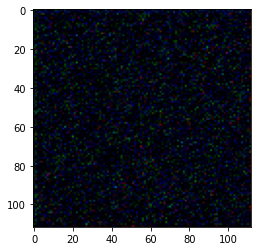

In [43]:
plt.imshow(conv1_out[0][..., random_idx:random_idx+3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


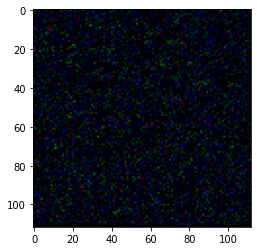

In [44]:
plt.imshow(conv1_out_tf[0][..., random_idx:random_idx+3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


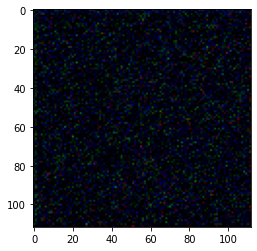

In [45]:
plt.imshow(conv1_out_tf_v2[0][..., random_idx:random_idx+3])

In [46]:
conv1_out

array([[[[-0.13276066, -0.13830505, -0.15496743, ..., -0.08549852,
           0.19768798,  0.17046818],
         [-0.21519405, -0.3537839 , -0.0277861 , ..., -0.1898058 ,
          -0.26318985, -0.06500708],
         [-0.16235328, -0.3972794 , -0.08561654, ..., -0.41346213,
          -0.08131464, -0.01638666],
         ...,
         [-0.23913108, -0.34624973,  0.18264359, ..., -0.5791591 ,
           0.13436711,  0.03361887],
         [-0.24473926, -0.24335589, -0.0652998 , ..., -0.22775581,
           0.09281957, -0.1590988 ],
         [-0.09249313, -0.35378048, -0.07952   , ..., -0.21185726,
           0.04125006,  0.06985912]],

        [[-0.29540426, -0.04289302, -0.23841849, ..., -0.27620336,
          -0.0546531 , -0.06836853],
         [-0.59118307,  0.07882877,  0.19456773, ..., -0.2622317 ,
          -0.32462034,  0.17746484],
         [-0.20266204, -0.22821973, -0.03677895, ..., -0.45398402,
           0.10973217,  0.26660663],
         ...,
         [-0.09621132, -0.26367053

In [47]:
conv1_out_tf_v2

array([[[[-0.13276066, -0.13830505, -0.15496737, ..., -0.08549853,
           0.19768795,  0.17046818],
         [-0.21519399, -0.35378385, -0.02778606, ..., -0.18980582,
          -0.2631898 , -0.06500708],
         [-0.16235326, -0.39727947, -0.08561661, ..., -0.4134622 ,
          -0.0813147 , -0.01638663],
         ...,
         [-0.23913111, -0.34624985,  0.1826436 , ..., -0.579159  ,
           0.1343671 ,  0.03361886],
         [-0.24473925, -0.24335589, -0.06529988, ..., -0.22775573,
           0.09281957, -0.15909886],
         [-0.09249312, -0.35378042, -0.07951999, ..., -0.21185729,
           0.04125008,  0.06985914]],

        [[-0.2954043 , -0.04289303, -0.23841853, ..., -0.27620327,
          -0.05465312, -0.06836853],
         [-0.5911831 ,  0.07882883,  0.19456771, ..., -0.2622318 ,
          -0.32462037,  0.17746483],
         [-0.20266198, -0.2282197 , -0.03677899, ..., -0.45398405,
           0.1097322 ,  0.2666067 ],
         ...,
         [-0.09621134, -0.26367053

In [48]:
conv1_out_tf

array([[[[-1.96716264e-01, -1.28129944e-01,  4.63796631e-02, ...,
          -2.64614493e-01,  1.42353907e-01, -3.67096774e-02],
         [-1.29715428e-01, -1.35370120e-01,  1.02844357e-01, ...,
          -3.82643193e-01, -3.72844577e-01, -1.05029523e-01],
         [-3.70247453e-01, -3.66576463e-01, -1.06397472e-01, ...,
          -3.64379913e-01,  4.09602746e-02,  2.22268224e-01],
         ...,
         [-1.21614173e-01, -4.72772926e-01, -1.36180535e-01, ...,
          -4.51728642e-01,  4.27082069e-02, -1.17668971e-01],
         [-1.32359177e-01, -7.55616054e-02, -2.60732160e-03, ...,
          -3.65502536e-01, -6.56204820e-02,  3.80104594e-02],
         [-1.10026479e-01, -1.22251131e-01, -1.05879456e-01, ...,
          -1.72815114e-01, -9.90334898e-02, -5.07295132e-02]],

        [[-1.09605886e-01, -2.04851255e-01, -4.83940281e-02, ...,
          -2.94465482e-01, -3.23008746e-01,  3.20965827e-01],
         [-9.15861055e-02, -3.34548295e-01, -7.52474070e-02, ...,
          -4.93095875e

### Verify prediction

In [49]:
fixed_input = np.random.rand(16, 224, 224, 3).astype(np.float32)

In [50]:
fixed_input.dtype

dtype('float32')

In [51]:
pred_tf = net_tf(fixed_input, training=False)

In [52]:
pred_tf[0].shape

TensorShape([16, 28, 28, 128])

In [53]:
net.eval()

Resnet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [54]:
pred = net(torch.from_numpy(fixed_input).permute(0, 3, 1, 2))

In [55]:
pred[0].shape

torch.Size([16, 128, 28, 28])

In [56]:
np.allclose(pred_tf[0].numpy(), np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1)))

False

In [57]:
pred_tf[0].numpy()

array([[[[3.79445516e-02, 5.45376480e-01, 0.00000000e+00, ...,
          0.00000000e+00, 4.62846518e-01, 6.75866380e-02],
         [4.05118555e-01, 2.61813432e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.58695477e-01, 3.31441388e-02],
         [4.01014507e-01, 5.09977102e-01, 4.58823442e-02, ...,
          0.00000000e+00, 3.58911932e-01, 1.66443288e-01],
         ...,
         [7.98044801e-01, 4.96309400e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.89602214e-01, 0.00000000e+00],
         [4.38839167e-01, 5.29948711e-01, 0.00000000e+00, ...,
          0.00000000e+00, 4.93967354e-01, 1.75533429e-01],
         [0.00000000e+00, 4.99726355e-01, 1.29476592e-01, ...,
          2.22419322e-01, 6.36546671e-01, 2.18054831e-01]],

        [[0.00000000e+00, 4.30975854e-01, 0.00000000e+00, ...,
          0.00000000e+00, 4.44306999e-01, 4.21455652e-01],
         [1.05844006e-01, 9.82022285e-03, 0.00000000e+00, ...,
          0.00000000e+00, 5.35961501e-02, 1.94043413e-01],
        

In [58]:
np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))

array([[[[4.18849885e-02, 5.53408861e-01, 0.00000000e+00, ...,
          0.00000000e+00, 4.66804445e-01, 6.61574751e-02],
         [4.07055765e-01, 2.56163955e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.60587537e-01, 2.76037194e-02],
         [4.01918173e-01, 5.10492384e-01, 5.48970997e-02, ...,
          0.00000000e+00, 3.63955051e-01, 1.64377257e-01],
         ...,
         [8.08947802e-01, 5.02153397e-01, 0.00000000e+00, ...,
          0.00000000e+00, 3.94326180e-01, 0.00000000e+00],
         [4.45206434e-01, 5.34108043e-01, 0.00000000e+00, ...,
          0.00000000e+00, 5.02235651e-01, 1.73199102e-01],
         [0.00000000e+00, 5.10276914e-01, 1.36727661e-01, ...,
          2.18206048e-01, 6.46219254e-01, 2.20669016e-01]],

        [[0.00000000e+00, 4.33303744e-01, 0.00000000e+00, ...,
          0.00000000e+00, 4.50545371e-01, 4.28813934e-01],
         [1.09336749e-01, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 4.92378622e-02, 1.96141347e-01],
        

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


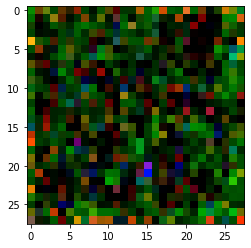

In [59]:
plt.imshow(pred_tf[0].numpy()[0][..., :3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


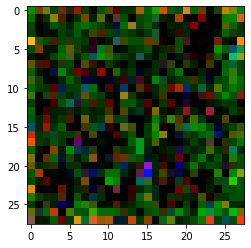

In [60]:
plt.imshow(np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))[0][..., :3])

In [61]:
np.abs(
    pred_tf[0].numpy()[0][..., :3] \
    - np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))[0][..., :3]
).max()

0.028271794

In [212]:
np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))[0][..., :3].max()

1.2951542

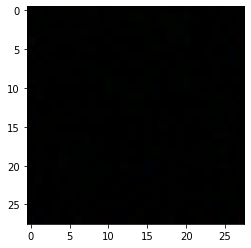

In [214]:
plt.imshow(
    np.abs(
        pred_tf[0].numpy()[0][..., :3] \
        - np.transpose(pred[0].detach().numpy(), (0, 2, 3, 1))[0][..., :3]
    )
)

In [246]:
class ConvBNReLU(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, ks=3, stride=1, padding=1, *args, **kwargs):
        super(ConvBNReLU, self).__init__()
        
        self.conv = Conv2D(
            out_chan,
            kernel_size=ks,
            strides=stride,
            padding=padding,
            use_bias=False
        )
        
        self.bn = keras.layers.BatchNormalization()

    def call(self, x, training=False):
        x = self.conv(x)
        x = K.relu(self.bn(x, training=training))
        return x
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in ["conv", "bn"]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [247]:
from model import ConvBNReLU as THConvBNReLU

In [248]:
conv_bn_relu = THConvBNReLU(in_chan=3, out_chan=3)

In [249]:
conv_bn_relu

ConvBNReLU(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [250]:
conv_bn_relu_tf = ConvBNReLU(in_chan=3, out_chan=3)

In [251]:
dummy = tf.random.normal((2, 224, 224, 3), dtype=tf.float32)
_ = conv_bn_relu_tf(dummy)

In [252]:
dummy.shape

TensorShape([2, 224, 224, 3])

In [253]:
conv_bn_relu_tf.load_weights_pytorch(
    conv_bn_relu.state_dict()
)

ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!


In [254]:
conv_bn_relu.eval()

ConvBNReLU(
  (conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [255]:
out = conv_bn_relu(torch.from_numpy(dummy.numpy()).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()

In [256]:
out.shape

(2, 224, 224, 3)

In [257]:
out_tf = conv_bn_relu_tf(dummy, training=False)
out_tf = out_tf.numpy()

In [258]:
out_tf.shape

(2, 224, 224, 3)

In [259]:
out[0]

array([[[0.        , 1.1430001 , 0.13274392],
        [0.8580169 , 0.        , 0.84968585],
        [0.        , 0.        , 0.        ],
        ...,
        [0.13557081, 0.6424151 , 0.        ],
        [0.        , 0.        , 0.58048004],
        [0.1881206 , 0.        , 0.41892347]],

       [[1.0491261 , 0.        , 0.        ],
        [0.12463615, 2.9819536 , 1.3785894 ],
        [0.5280587 , 0.16201244, 1.4000502 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.11551423, 1.6653554 , 0.        ],
        [0.2681795 , 0.        , 0.        ]],

       [[0.00550683, 0.        , 0.938733  ],
        [0.        , 0.        , 0.        ],
        [1.3068948 , 1.2960026 , 0.14402474],
        ...,
        [0.13308497, 0.        , 0.77242917],
        [0.        , 3.2683747 , 0.        ],
        [0.8882792 , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.5752187 ],
        [0.        , 1.1994684 , 0.74458796],
        [0.        , 0

In [260]:
out_tf[0]

array([[[0.        , 1.1424346 , 0.13267824],
        [0.85759246, 0.        , 0.8492656 ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.13550375, 0.64209735, 0.        ],
        [0.        , 0.        , 0.580193  ],
        [0.18802755, 0.        , 0.41871628]],

       [[1.0486072 , 0.        , 0.        ],
        [0.12457447, 2.9804783 , 1.3779074 ],
        [0.52779746, 0.16193241, 1.3993578 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.1154571 , 1.6645316 , 0.        ],
        [0.2680469 , 0.        , 0.        ]],

       [[0.00550408, 0.        , 0.93826866],
        [0.        , 0.        , 0.        ],
        [1.3062483 , 1.2953615 , 0.1439535 ],
        ...,
        [0.13301903, 0.        , 0.77204704],
        [0.        , 3.266758  , 0.        ],
        [0.8878399 , 0.        , 0.        ]],

       ...,

       [[0.        , 0.        , 0.5749341 ],
        [0.        , 1.1988751 , 0.7442197 ],
        [0.        , 0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


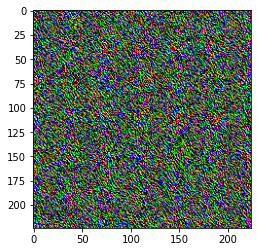

In [261]:
plt.imshow(out[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


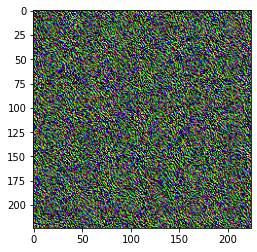

In [262]:
plt.imshow(out_tf[0])

In [263]:
np.allclose(out_tf, out)

False

In [264]:
(out_tf.min(), out_tf.max()), (out.min(), out.max())

((0.0, 5.5346527), (0.0, 5.537392))

In [268]:
np.abs(out_tf - out).max()/max(out_tf.max(), out.max()) * 100

0.04947147099301219

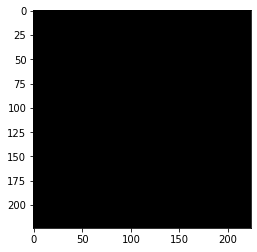

In [266]:
plt.imshow(np.abs(out_tf[0] - out[0]))

In [64]:
class BiSeNetOutput(keras.layers.Layer):
    def __init__(self, in_chan, mid_chan, n_classes, *args, **kwargs):
        super(BiSeNetOutput, self).__init__()
        
        self.conv = ConvBNReLU(
            in_chan, 
            mid_chan, 
            ks=3, 
            stride=1, 
            padding=1
        )
        self.conv_out = Conv2D(
#             mid_chan, 
            n_classes, 
            kernel_size=1, 
            use_bias=False
        )

    def call(self, x, training=False):
        x = self.conv(x, training=training)
        x = self.conv_out(x, training=training)
        return x
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "conv", 
            "conv_out"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
            
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [284]:
from model import BiSeNetOutput as THBiseNetOutput

In [285]:
bisenetoutput = THBiseNetOutput(3, 3, 3)

In [286]:
bisenetoutput.eval()

out = bisenetoutput(torch.from_numpy(dummy.numpy()).permute(0, 3, 1, 2))
out = out.permute(0, 2, 3, 1).detach().numpy()

In [287]:
bisenetoutput_tf = BiSeNetOutput(3, 3, 3)

In [288]:
out_tf = bisenetoutput_tf(dummy, training=False)

In [289]:
bisenetoutput_tf.load_weights_pytorch(bisenetoutput.state_dict())

BiSeNetOutput: Setting weight for layer: conv, type: ConvBNReLU
BiSeNetOutput: layer_state_dict keys: ['conv.weight', 'bn.weight', 'bn.bias', 'bn.running_mean', 'bn.running_var', 'bn.num_batches_tracked']
ConvBNReLU: Setting weight for layer: conv, type: Conv2D
ConvBNReLU: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
ConvBNReLU: conv:Done!

ConvBNReLU: Setting weight for layer: bn, type: BatchNormalization
ConvBNReLU: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']
ConvBNReLU: bn:Done!

ConvBNReLU: Done loading weights!!!
BiSeNetOutput: conv:Done!

BiSeNetOutput: Setting weight for layer: conv_out, type: Conv2D
BiSeNetOutput: layer_state_dict keys: ['weight']
Conv2D set_weights() called.
BiSeNetOutput: conv_out:Done!

BiSeNetOutput: Done loading weights!!!


In [290]:
out_tf = bisenetoutput_tf(dummy, training=False)
out_tf = out_tf.numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


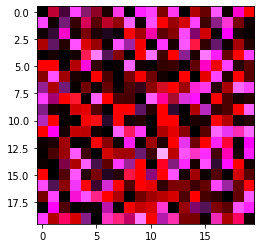

In [296]:
plt.imshow(out[0][:20,:20,:])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


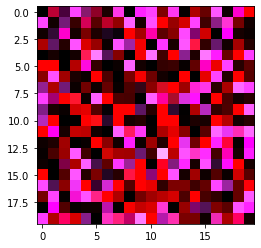

In [295]:
plt.imshow(out_tf[0][:20,:20,:])

In [293]:
out_tf[0]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.74477136, -0.37758192,  0.2066894 ],
        [ 0.2890519 ,  0.00648218,  0.23709592],
        ...,
        [ 0.91698027, -0.5749545 ,  0.08990961],
        [ 1.417349  ,  0.26052618,  1.117831  ],
        [ 0.21796618, -0.07822119, -0.31557333]],

       [[ 1.2131443 ,  0.2814737 ,  1.2557569 ],
        [ 0.06931416, -0.58445936, -0.5439146 ],
        [ 0.45766658,  0.10618778,  0.47374246],
        ...,
        [ 0.10262735, -0.8653573 , -0.8053263 ],
        [ 1.7366356 ,  0.15227486,  1.2457225 ],
        [ 0.36565936, -0.0856962 , -0.49331698]],

       [[ 0.06497607, -0.5478805 , -0.5098733 ],
        [ 0.2013873 ,  0.04672587,  0.20846118],
        [ 1.5624117 , -0.43370816,  0.8010245 ],
        ...,
        [ 0.60850316, -0.14260925, -0.8209415 ],
        [ 0.0726524 , -0.61260754, -0.57011014],
        [ 0.5352887 , -0.611659  , -1.107565  ]],

       ...,

       [[ 0.17018576, -0.03988486, -0.22960037],
        [ 0

In [294]:
out[0]

array([[[ 0.        ,  0.        ,  0.        ],
        [ 0.7451402 , -0.37776873,  0.2067919 ],
        [ 0.28919494,  0.00648541,  0.23721327],
        ...,
        [ 0.91743416, -0.575239  ,  0.08995429],
        [ 1.4180505 ,  0.26065508,  1.1183842 ],
        [ 0.21807402, -0.0782599 , -0.31572947]],

       [[ 1.2137445 ,  0.28161296,  1.2563783 ],
        [ 0.06934848, -0.5847487 , -0.54418385],
        [ 0.45789322,  0.10624037,  0.47397706],
        ...,
        [ 0.10267813, -0.8657855 , -0.80572474],
        [ 1.7374951 ,  0.15235017,  1.246339  ],
        [ 0.36584038, -0.08573862, -0.49356118]],

       [[ 0.06500823, -0.5481516 , -0.5101256 ],
        [ 0.20148681,  0.04674896,  0.20856419],
        [ 1.5631847 , -0.43392283,  0.80142087],
        ...,
        [ 0.6088043 , -0.14267983, -0.8213478 ],
        [ 0.07268836, -0.61291075, -0.5703923 ],
        [ 0.53555363, -0.6119618 , -1.1081133 ]],

       ...,

       [[ 0.17026997, -0.0399046 , -0.22971399],
        [ 0

In [298]:
np.abs(out_tf - out).max()/max(out_tf.max(), out.max())

0.0004947249

In [65]:
class AttentionRefinementModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(AttentionRefinementModule, self).__init__()
        
        self.conv = ConvBNReLU(
            in_chan, 
            out_chan, 
            ks=3, 
            stride=1, 
            padding=1
        )
        
        self.conv_atten = Conv2D(
#           out_chan, 
            out_chan, 
            kernel_size=1, 
            use_bias=False
        )
        
        self.bn_atten = keras.layers.BatchNormalization()
        self.sigmoid_atten = keras.layers.Activation("sigmoid")
        
    def call(self, x, training=False):
        feat = self.conv(x, training=training)
        
        atten = K.pool2d(feat, 
                         pool_size=feat.shape[2:3+1],
                         pool_mode="avg",
                         padding="same")
    
        atten = self.conv_atten(atten)
        atten = self.bn_atten(atten, training=training)
        atten = self.sigmoid_atten(atten)
        out = tf.math.multiply(feat, atten)
        return out
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "conv", 
            "conv_atten",
            "bn_atten"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [66]:
class ContextPath(keras.layers.Layer):
    def __init__(self, *args, **kwargs):
        super(ContextPath, self).__init__()
        
        self.resnet = TFResnet18()
        self.arm16 = AttentionRefinementModule(256, 128)
        self.arm32 = AttentionRefinementModule(512, 128)
        self.conv_head32 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_head16 = ConvBNReLU(128, 128, ks=3, stride=1, padding=1)
        self.conv_avg = ConvBNReLU(512, 128, ks=1, stride=1, padding=0)
        
    def call(self, x, training=False):
        H0, W0 = x.shape[1:2+1]
        
        feat8, feat16, feat32 = self.resnet(x, training=training)
        
        H8, W8 = feat8.shape[1:2+1]
        H16, W16 = feat16.shape[1:2+1]
        H32, W32 = feat32.shape[1:2+1]

        avg = K.pool2d(feat32, 
                       pool_size=feat32.shape[1:2+1],
                       pool_mode="avg",
                       padding="same")
        avg = self.conv_avg(avg, training=training)
        avg_up = tf.compat.v1.image.resize_nearest_neighbor(avg, 
                                 (H32, W32))

        feat32_arm = self.arm32(feat32, training=training)
        feat32_sum = feat32_arm + avg_up
        feat32_up = tf.compat.v1.image.resize_nearest_neighbor(feat32_sum, 
                                    (H16, W16))
        feat32_up = self.conv_head32(feat32_up, training=training)

        feat16_arm = self.arm16(feat16, training=training)
        feat16_sum = feat16_arm + feat32_up
        feat16_up = tf.compat.v1.image.resize_nearest_neighbor(feat16_sum, 
                                  (H8, W8))
        feat16_up = self.conv_head16(feat16_up, training=training)

        return feat8, feat16_up, feat32_up  # x8, x8, x16
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "resnet", 
            "arm16",
            "arm32",
            "conv_head32",
            "conv_head16",
            "conv_avg"
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [67]:
class FeatureFusionModule(keras.layers.Layer):
    def __init__(self, in_chan, out_chan, *args, **kwargs):
        super(FeatureFusionModule, self).__init__()
        
        self.convblk = ConvBNReLU(
            in_chan,
            out_chan,
            ks=1,
            stride=1,
            padding=0
        )
        
        self.conv1 = Conv2D(
#             out_chan,
            out_chan//4,
            kernel_size=1,
            strides=1,
            padding=0,
            use_bias=False
        )
        self.conv2 = Conv2D(
#             out_chan//4,
            out_chan,
            kernel_size=1,
            strides=1,
            padding=0,
            use_bias=False
        )

    def call(self, inputs, training=False):
        fsp, fcp = inputs
        
        fcat = K.concatenate([fsp, fcp], axis=3)
        
        feat = self.convblk(fcat, training=training)
        
        atten = K.pool2d(feat, 
                         pool_size=feat.shape[1:2+1], 
                         pool_mode="avg",
                         padding="same")
        atten = self.conv1(atten)
        atten = K.relu(atten)
        atten = self.conv2(atten)
        atten = K.sigmoid(atten)
        
        feat_atten = tf.math.multiply(feat, atten)
        
        feat_out = feat_atten + feat
        return feat_out
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "convblk", 
            "conv1",
            "conv2",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [68]:
class TFBiSeNet(keras.models.Model):
    def __init__(self, n_classes, *args, **kwargs):
        super(TFBiSeNet, self).__init__()
        
        self.cp = ContextPath()
        ## here self.sp is deleted
        
        self.ffm = FeatureFusionModule(256, 256)
        
        self.conv_out = BiSeNetOutput(256, 256, n_classes)
        self.conv_out16 = BiSeNetOutput(128, 64, n_classes)
        self.conv_out32 = BiSeNetOutput(128, 64, n_classes)

    def call(self, x, training=False):
        H, W = x.shape[1:2+1]
    
        feat_res8, feat_cp8, feat_cp16 = self.cp(x, training=training)  # here return res3b1 feature
        
        feat_sp = feat_res8  # use res3b1 feature to replace spatial path feature
        feat_fuse = self.ffm((feat_sp, feat_cp8), training=training)

        feat_out = self.conv_out(feat_fuse, training=training)
        feat_out16 = self.conv_out16(feat_cp8, training=training)
        feat_out32 = self.conv_out32(feat_cp16, training=training)

        feat_out = tf.compat.v1.image.resize_bilinear(feat_out, 
                                                      (H, W))
        feat_out16 = tf.compat.v1.image.resize_bilinear(feat_out16, 
                                                        (H, W))
        feat_out32 = tf.compat.v1.image.resize_bilinear(feat_out32, 
                                                        (H, W))
        
        return feat_out, feat_out16, feat_out32
    
    def load_weights_pytorch(self, state_dict):
        for layer_name in [
            "cp", 
            "ffm",
            "conv_out",
            "conv_out16",
            "conv_out32",
        ]:
            layer = getattr(self, layer_name)
            
            layer_state_dict = filter_dict_by_name(layer_name, state_dict)
            layer_state_dict = strip_dict_key_prefix(layer_state_dict, 1)
            
            print(f"{self.__class__.__name__}: Setting weight for layer: {layer_name}, type: {layer.__class__.__name__}")
            print(f"{self.__class__.__name__}: layer_state_dict keys: {list(layer_state_dict.keys())}")

            if isinstance(layer, 
                          (
                              keras.layers.Conv2D,
                              keras.layers.BatchNormalization,
                              Conv2D
                          )):
                layer.set_weights(get_weight_conversion_fn(layer)(layer_state_dict))
            else:
                layer.load_weights_pytorch(layer_state_dict)
                
            print(f"{self.__class__.__name__}: {layer_name}:Done!\n")
                
        print(f"{self.__class__.__name__}: Done loading weights!!!")

In [69]:
model_state_dict = torch.load(os.path.join("res/cp", "79999_iter.pth"))

print(f"{'Parameter':80s}Size")
print("-" * 100)
for k, v in model_state_dict.items():
    print(f"{k:80s}{list(v.shape)}")

Parameter                                                                       Size
----------------------------------------------------------------------------------------------------
cp.resnet.conv1.weight                                                          [64, 3, 7, 7]
cp.resnet.bn1.weight                                                            [64]
cp.resnet.bn1.bias                                                              [64]
cp.resnet.bn1.running_mean                                                      [64]
cp.resnet.bn1.running_var                                                       [64]
cp.resnet.bn1.num_batches_tracked                                               []
cp.resnet.layer1.0.conv1.weight                                                 [64, 64, 3, 3]
cp.resnet.layer1.0.bn1.weight                                                   [64]
cp.resnet.layer1.0.bn1.bias                                                     [64]
cp.resnet.layer1.0.bn1.running_m

In [70]:
net = load_pytorch_model()

In [71]:
net.load_state_dict(model_state_dict)

<All keys matched successfully>

In [72]:
net.eval()

BiSeNet(
  (cp): ContextPath(
    (resnet): Resnet18(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [73]:
net_tf = TFBiSeNet(n_classes=19)

In [74]:
in_ten = torch.randn(2, 3, 640, 480)

In [75]:
out, out16, out32 = net(in_ten)

print(f"out.shape: {out.shape}")
print(f"out16.shape: {out16.shape}")
print(f"out32.shape: {out32.shape}")

out.shape: torch.Size([2, 19, 640, 480])
out16.shape: torch.Size([2, 19, 640, 480])
out32.shape: torch.Size([2, 19, 640, 480])


In [76]:
out_tf, out16_tf, out32_tf = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [77]:
net_tf.load_weights_pytorch(model_state_dict)

TFBiSeNet: Setting weight for layer: cp, type: ContextPath
TFBiSeNet: layer_state_dict keys: ['resnet.conv1.weight', 'resnet.bn1.weight', 'resnet.bn1.bias', 'resnet.bn1.running_mean', 'resnet.bn1.running_var', 'resnet.bn1.num_batches_tracked', 'resnet.layer1.0.conv1.weight', 'resnet.layer1.0.bn1.weight', 'resnet.layer1.0.bn1.bias', 'resnet.layer1.0.bn1.running_mean', 'resnet.layer1.0.bn1.running_var', 'resnet.layer1.0.bn1.num_batches_tracked', 'resnet.layer1.0.conv2.weight', 'resnet.layer1.0.bn2.weight', 'resnet.layer1.0.bn2.bias', 'resnet.layer1.0.bn2.running_mean', 'resnet.layer1.0.bn2.running_var', 'resnet.layer1.0.bn2.num_batches_tracked', 'resnet.layer1.1.conv1.weight', 'resnet.layer1.1.bn1.weight', 'resnet.layer1.1.bn1.bias', 'resnet.layer1.1.bn1.running_mean', 'resnet.layer1.1.bn1.running_var', 'resnet.layer1.1.bn1.num_batches_tracked', 'resnet.layer1.1.conv2.weight', 'resnet.layer1.1.bn2.weight', 'resnet.layer1.1.bn2.bias', 'resnet.layer1.1.bn2.running_mean', 'resnet.layer1.1.b

TFResnet18: Setting weight for layer: conv1, type: Conv2D
TFResnet18: layer_state_dict keys: ['weight']

TFResnet18: Setting weight for layer: bn1, type: BatchNormalization
TFResnet18: layer_state_dict keys: ['weight', 'bias', 'running_mean', 'running_var', 'num_batches_tracked']

TFResnet18: Sequential layer: layer1
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!
TFResnet18: 	idx: 1, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBlock: Setting weight for layer: conv2
BasicBlock: Setting weight for layer: bn2
BasicBlock: Done loading weights!!!

TFResnet18: Sequential layer: layer2
TFResnet18: 	idx: 0, layer type: BasicBlock
BasicBlock: Setting weight for layer: conv1
BasicBlock: Setting weight for layer: bn1
BasicBloc

In [78]:
out_tf, out16_tf, out32_tf = net_tf(in_ten.permute(0, 2, 3, 1).detach().numpy())

In [79]:
print(f"out_tf.shape: {out_tf.shape}")
print(f"out16_tf.shape: {out16_tf.shape}")
print(f"out32_tf.shape: {out32_tf.shape}")

out_tf.shape: (2, 640, 480, 19)
out16_tf.shape: (2, 640, 480, 19)
out32_tf.shape: (2, 640, 480, 19)


In [80]:
net_tf.summary()

Model: "tf_bi_se_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
context_path (ContextPath)   multiple                  12467648  
_________________________________________________________________
feature_fusion_module (Featu multiple                  99328     
_________________________________________________________________
bi_se_net_output (BiSeNetOut multiple                  595712    
_________________________________________________________________
bi_se_net_output_1 (BiSeNetO multiple                  75200     
_________________________________________________________________
bi_se_net_output_2 (BiSeNetO multiple                  75200     
Total params: 13,313,088
Trainable params: 13,300,416
Non-trainable params: 12,672
_________________________________________________________________


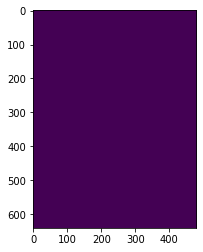

In [81]:
plt.imshow(np.argmax(out.permute(0, 2, 3, 1)[0].detach().numpy(), -1))

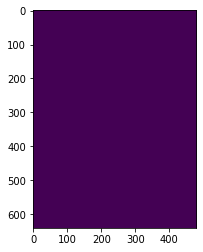

In [82]:
plt.imshow(np.argmax(out_tf[0].numpy(), -1))

In [83]:
from test import vis_parsing_maps
from PIL import Image
from torchvision import transforms

In [84]:
def predict(net, image_path, save_path):
    net.eval()
    
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225)
        ),
    ])
    
    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        
#         img = img.cuda()
        
        out = net(img)[0]
        parsing = out.squeeze(0).cpu().numpy().argmax(0)
        print(parsing)
        print(parsing.shape)
        print(np.unique(parsing))

        vis_parsing_maps(image, parsing, stride=1, save_im=True, save_path=save_path)

In [85]:
predict(net, "./0.jpg", "pred0.jpg")

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]
 [17 17 17 ... 17 17 17]]
(512, 512)
[ 0  1  2  3  4  5 10 11 12 13 14 17 18]


In [86]:
def predict_tf(net, image_path, save_path):    
    to_tensor = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406), 
            (0.229, 0.224, 0.225)
        ),
    ])
    
    with torch.no_grad():
        img = Image.open(image_path)
        image = img.resize((512, 512), Image.BILINEAR)
        img = to_tensor(image)
        img = torch.unsqueeze(img, 0)
        
#         img = img.cuda()
        
        img = img.detach().numpy()
        img = np.transpose(img, (0, 2, 3, 1))
        print(f"img shape: {img.shape}")

        out = net(img, training=False)[0]
        print(f"out shape: {out.shape}")
        parsing = np.argmax(np.squeeze(out, 0), 2)
        print(parsing.shape)
        print(np.unique(parsing))

        vis_parsing_maps(image, parsing, stride=1, save_im=True, save_path=save_path)

In [87]:
predict_tf(net_tf, "./0.jpg", "pred0-tf.jpg")

img shape: (1, 512, 512, 3)
out shape: (1, 512, 512, 19)
(512, 512)
[ 0  1  2  3  4  5 10 11 12 13 14 16 17 18]
